In [2]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import pingouin as pg
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf

df = pd.read_csv("1st-dataset-prepressed-baseball.csv")     # 1차 데이터셋

pd.set_option("display.max_columns", None)

# 분석용 편의 함수
def pct(n): return f"{n:.1%}"

# df['accident_score'] = df['accident_count'] + 3 * df['injury_count'] + 10 * df['death_count']
df['accident_score'] = df['accident_count'] + 3 * df['injury_count']


df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2072 entries, 0 to 2071
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   game_id         2072 non-null   int64  
 1   stadium_code    2072 non-null   object 
 2   sports_type     2072 non-null   object 
 3   game_date       2072 non-null   object 
 4   day_of_week     2072 non-null   object 
 5   is_holiday      2072 non-null   int64  
 6   start_time      2072 non-null   object 
 7   home_team_win   2072 non-null   int64  
 8   audience        2072 non-null   float64
 9   region          2072 non-null   object 
 10  accident_count  2072 non-null   float64
 11  injury_count    2072 non-null   float64
 12  death_count     2072 non-null   float64
 13  temperature     2072 non-null   float64
 14  precipitation   2072 non-null   float64
 15  snow_depth      2072 non-null   float64
 16  start_hour      2072 non-null   int64  
 17  match_시범경기      2072 non-null   b

In [15]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# ▶ 데이터 준비
# 예: df = pd.read_csv('your_data.csv')
features = [
    'match_시범경기', 'match_정규시즌', 'match_포스트시즌',
    'is_holiday', 'start_hour', 'audience',
    'home_team_win', 'temperature', 'precipitation'
]
target = 'accident_score'


# 1. 독립 변수와 종속 변수 정의
X = df.drop(columns=["accident_score", "accident_count", "injury_count", "death_count", "game_id", "stadium_code","sports_type","game_date", "day_of_week", "start_time", "region", "snow_depth"])
y = df['accident_score']

#
# ▶ X, y 분리
#X = df[features].copy()
#y = df[target].copy()

# ▶ 필요시 정규화 (RandomForest는 정규화 불필요하나 비교를 위해 선택적으로 가능)
# scaler = StandardScaler()
# X[['audience', 'temperature', 'precipitation', 'start_hour']] = scaler.fit_transform(X[['audience', 'temperature', 'precipitation', 'start_hour']])

# ▶ 학습/테스트 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)



In [16]:
# 랜덤포레스트 + GridSearchCV 세팅
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt']
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    scoring='r2',
    verbose=2
)

# ▶ 하이퍼파라미터 튜닝 수행
grid_search.fit(X_train, y_train)

# ▶ 최적 모델로 예측
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# ▶ 성능 출력
print("✅ Best Parameters:", grid_search.best_params_)
print(f"✅ MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"✅ R² Score: {r2_score(y_test, y_pred):.4f}")

# ▶ 변수 중요도 시각화
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)


Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total

/opt/anaconda3/envs/myFirstProj/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
72 fits failed out of a total of 144.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/myFirstProj/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/myFirstProj/lib/python3.13/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "/opt/anaconda3/envs/myFirstProj/lib/pyth

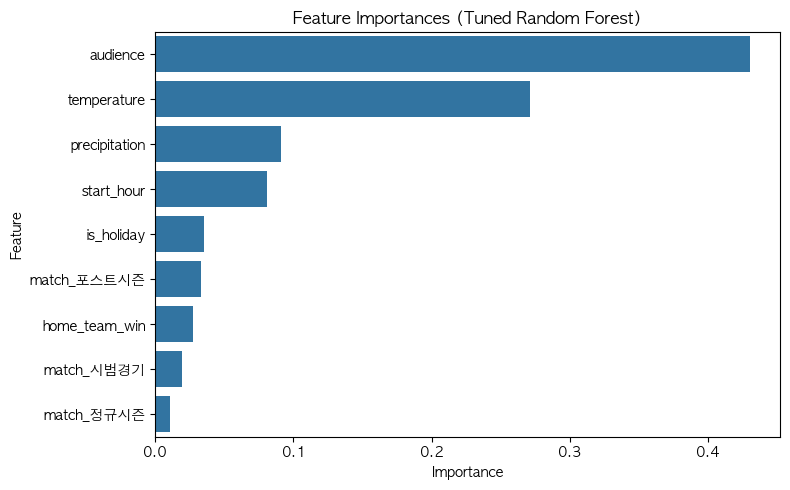

In [18]:
# ▶ 변수 중요도 시각화
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Apple 기본 폰트인 'AppleGothic' 사용
mpl.rcParams['font.family'] = 'AppleGothic'
# 음수 기호 깨짐 방지
mpl.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(8, 5))
sns.barplot(data=importances, x='Importance', y='Feature')
plt.title("Feature Importances (Tuned Random Forest)")
plt.tight_layout()
plt.show()

MSE: 524.4335
R² Score: 0.0471


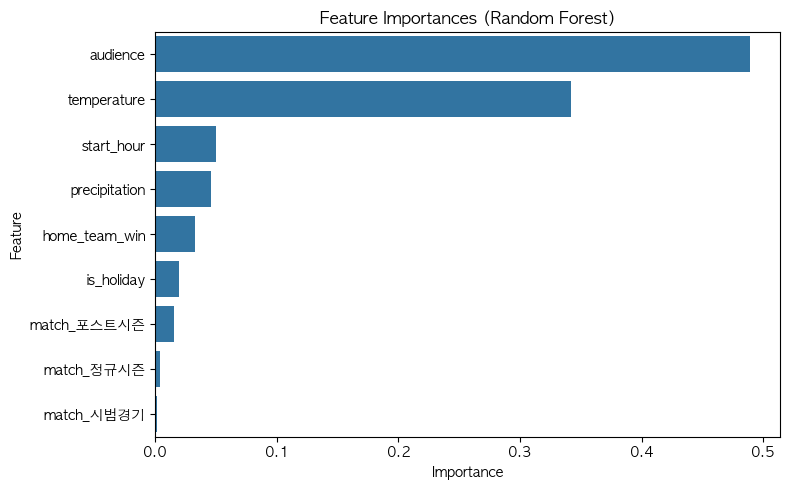

In [14]:
# 평가 지표 출력
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

# ▶ 중요 변수 시각화
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# -------------------- 3-4. 범주형 ↔ 사고건수 -----------------
# Apple 기본 폰트인 'AppleGothic' 사용
mpl.rcParams['font.family'] = 'AppleGothic'
# 음수 기호 깨짐 방지
mpl.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title("Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()
